<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/BITCOIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020년 Finacial Research Letters 논문
# Forecasting the price of Bitcoin using deep learning

- 논문 링크
https://reader.elsevier.com/reader/sd/pii/S1544612320304864?token=E422D53581ABDF2203778A6441A230D8245A63970E7BE7F602E91CF4F6AC2AADB12CCE276684CADE988FACCD54007A85&originRegion=us-east-1&originCreation=20210401041708

# 매우 복잡한 딥러닝을 사용했는데, 결과를 한번 볼까요?

무려 40개의 X변수를 사용하고 있습니다 (논문 참조).
일부 변수는 우리도 추가 사용 가능.

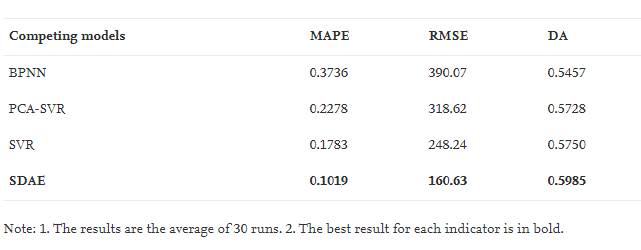

- DA가 테스트 데이터에 대한 방향(up/down) 예측의 정확성 비율 (hit rate)입니다. 59.85%
- 방향 예측에 대해 이것보다 더 좋은 모형을 만들어 보면 어떨까요?

# 딥러닝 모형의 문제점(특히 인공신경망)
https://indatalabs.com/blog/deep-learning-strengths-challenges

(Why a model should be interpretable? )
https://christophm.github.io/interpretable-ml-book/interpretability-importance.html

https://www.semanticscholar.org/paper/Towards-A-Rigorous-Science-of-Interpretable-Machine-Doshi-Velez-Kim/5c39e37022661f81f79e481240ed9b175dec6513

- Neural Networks at the Core of Deep Learning are Black Boxes
One of the most discussed limitations of deep learning is the fact that we don’t understand how a neural network arrives at a particular solution.

- It’s impossible to look inside of it to see how it works. Just like in a human brain, the reasoning of a neural network is embedded in the behavior of thousands of simulated neurons, arranged into dozens or even hundreds of intricately interconnected layers.

- Together they form a complex web where inputs are sent from one level to the next until an overall output is produced. Additionally, there is a process known as back-propagation that tweaks the calculations of individual neurons in a way that lets the network learn to produce the desired output faster.

- Even though neural networks produce great results, the lack of transparency in their “thinking” process makes it hard to predict when failures might occur. The same argument also renders them unsuitable for domains where verification of the process is important. One good example is medicine.

- Take, for example, Deep Patient, a deep learning program that was applied to patient records of more than 700.000 individuals at Mount Sinai Hospital in New York. After a long training period, Deep Patient was able to detect certain illnesses better than human doctors.

- On one hand, this is great news. On the other, if a tool like Deep Patient is actually going to be helpful to medical personnel, it needs to provide the reasoning for its prediction, to reassure their accuracy and to justify a change in someone’s treatment. Without the justification, it is difficult to gain the trust of patients or learn why any mistakes in diagnosis were made.

# Can you really interprete what the hidden neurons are?

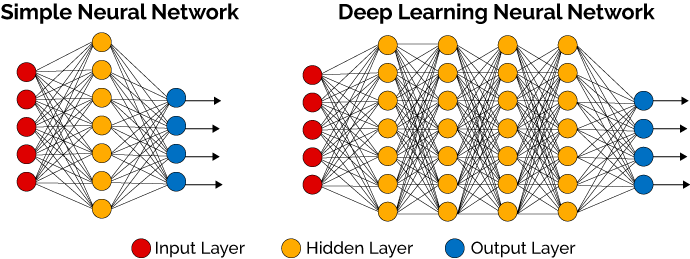

# ==> 데이터 요구량이 적고, 좀더 간단하고 해석가능한 ML 모형으로 딥러닝과 유사하거나, 오히려 더 나은 예측력을 가진다면??

# 논문 제목: Predicting the directional change of Bitcoin prices by an ensemble classification model 

# Import python modules 

In [ ]:
from sklearn.model_selection import train_test_split   
from sklearn import ensemble              
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
!pip install scikit-misc
!pip install pdpbox

# 데이터: Bitcoin Returns (2017.1.1~2021.3.20)
- 수익률로 변환

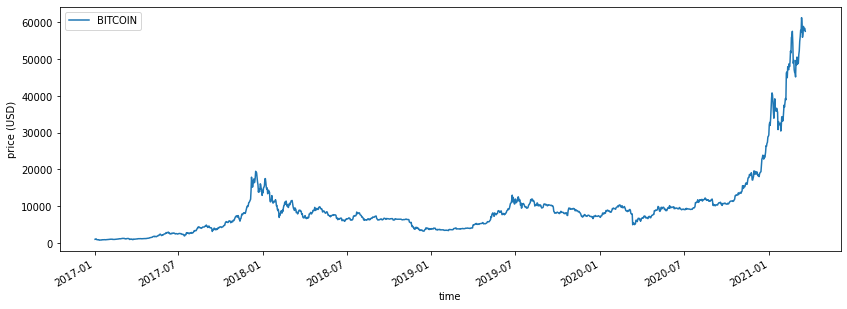

In [ ]:
import pandas_datareader as pdr
import datetime

df_null = pdr.get_data_yahoo(['BTC-USD'], 
                          start=datetime.datetime(2017, 1, 1), 
                          end=datetime.datetime(2021, 3, 20))['Close']

df1 = df_null.dropna()
df1["ROR"] = np.log(df1["BTC-USD"]).diff()
df1 = df1.dropna()
df1.head()

Y1=df1.ROR

fig, ax = plt.subplots(figsize=(14, 5))
df1.plot(y="BTC-USD", label='BITCOIN', ax=ax)
ax.set(xlabel='time', ylabel='price (USD)')
ax.legend();

#df1.plot(y="ROR", label='BITCOIN', ax=ax)
#ax.set(xlabel='time', ylabel='returns')
#ax.legend();



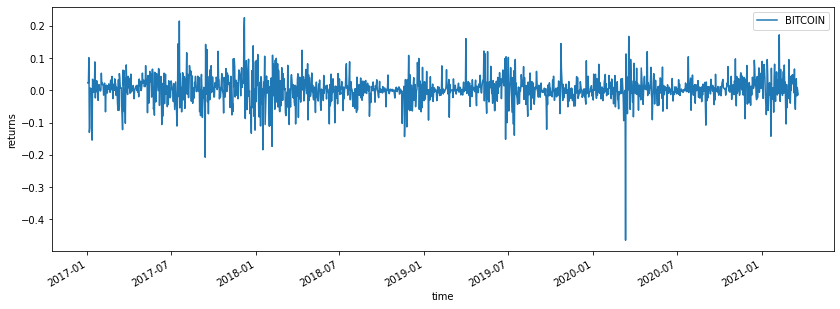

In [ ]:

fig, ax = plt.subplots(figsize=(14, 5))
df1.plot(y="ROR", label='BITCOIN', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();


# Dependent Variable

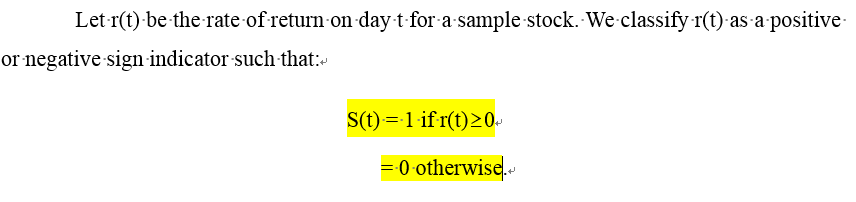

In [ ]:
T=len(Y1)
move2=-1*(Y1<0)  ## two states 
y=move2[1:].dropna()+1   
x=move2[0:T-1].dropna()+1
df=pd.DataFrame(y)
df.columns=['state(t)']
df["state(t-1)"]=x.values 
df

,state(t),state(t-1)
Date,,
2017-01-03,1,1
2017-01-04,1,1
2017-01-05,0,1
2017-01-06,0,0
2017-01-07,1,0
...,...,...
2021-03-17,1,1
2021-03-18,0,1
2021-03-19,1,0


# Pre-Analysis

# Markov Transition

In [ ]:
pd.crosstab(df['state(t-1)'], df['state(t)'] , margins=True)


state(t),0,1,All
state(t-1),,,
0,289,398,687
1,399,449,848
All,688,847,1535


# Decision Tree
(interpretability) https://christophm.github.io/interpretable-ml-book/tree.html

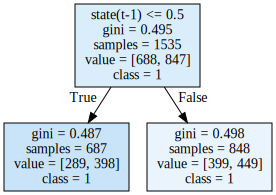

In [ ]:
y_train=df['state(t)']
X_train=pd.DataFrame(df['state(t-1)'])
X_train

from sklearn.tree import DecisionTreeClassifier 

dt_clf = DecisionTreeClassifier(max_depth=5, random_state=156)
dt_clf.fit(X_train, y_train)
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names = ["0","1"], 
                           feature_names = ['state(t-1)'], impurity=True, filled=True)

import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

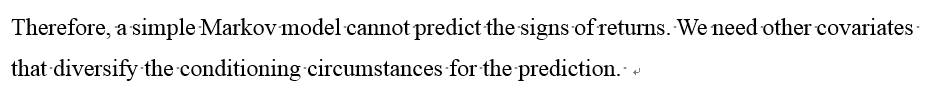

# Explanatory Variables

# 저번 논문과 달리 EWA 를 사용하려 합니다. 왜 이 변수냐? 이론적인 백업이 요구됩니다. 저는 잘 모릅니다. ㅎㅎ (기존 논문, 자산가격 결정이론 등). 

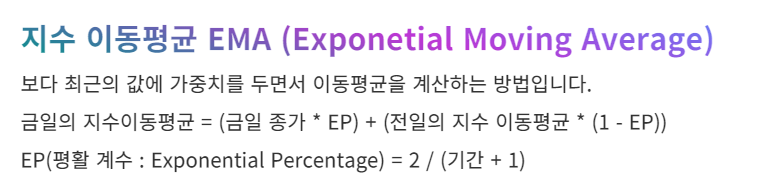

- 일단 윈도우 size가 3,10,30 을 사용

In [ ]:
x3 =Y1.ewm(3).mean()
x10=Y1.ewm(10).mean()
x30=Y1.ewm(30).mean()

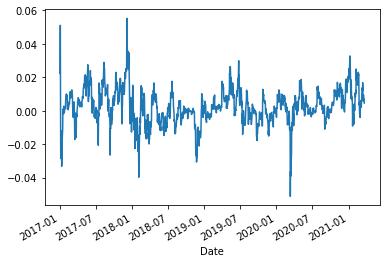

In [ ]:
x10.plot()

In [ ]:
y

Date
2017-01-03    1
2017-01-04    1
2017-01-05    0
2017-01-06    0
2017-01-07    1
             ..
2021-03-17    1
2021-03-18    0
2021-03-19    1
2021-03-20    0
2021-03-21    0
Name: ROR, Length: 1535, dtype: int64

In [ ]:
df["x3"]=x3[1:].values
df["x10"]=x10[1:].values
df["x30"]=x30[1:].values

In [ ]:
df

,state(t),state(t-1),x3,x10,x30
Date,,,,,
2017-01-03,1,1,0.022162,0.022248,0.022277
2017-01-04,1,1,0.056237,0.051022,0.049369
2017-01-05,0,1,-0.012083,-0.001058,0.002147
2017-01-06,0,0,-0.046214,-0.028673,-0.023102
2017-01-07,1,0,-0.030014,-0.021216,-0.017655
...,...,...,...,...,...
2021-03-17,1,1,0.009337,0.009334,0.009418
2021-03-18,0,1,0.002668,0.006909,0.008555
2021-03-19,1,0,0.004100,0.007044,0.008550


# Other covariates? 
https://www.sciencedirect.com/science/article/pii/S105752191830187X

https://www.etftrends.com/tactical-allocation-channel/bitcoins-correlation-to-markets-hits-a-record-in-2020/amp/

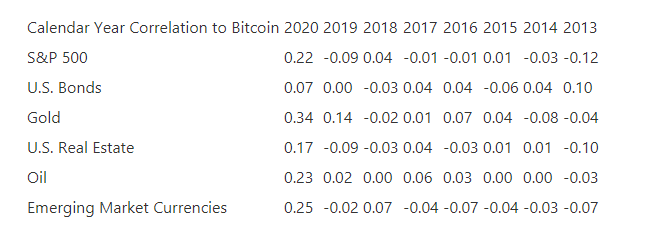

# Training/ Test set 

In [ ]:
del df["state(t)"]
X=df
y_train=y[0:1000]
y_test=y[1000:]
X_train=X[0:1000]
X_test=X[1000:]

In [ ]:
X_train

,state(t-1),x3,x10,x30
Date,,,,
2017-01-03,1,0.022162,0.022248,0.022277
2017-01-04,1,0.056237,0.051022,0.049369
2017-01-05,1,-0.012083,-0.001058,0.002147
2017-01-06,0,-0.046214,-0.028673,-0.023102
2017-01-07,0,-0.030014,-0.021216,-0.017655
...,...,...,...,...
2019-09-24,0,-0.032701,-0.015269,-0.005748
2019-09-25,0,-0.035609,-0.017911,-0.006993
2019-09-26,0,-0.022648,-0.014807,-0.006243


# Ensemble Model
Ensemble methods are techniques that create multiple models and then combine them to produce improved results. Ensemble methods usually produces more accurate solutions than a single model would. This has been the case in a number of machine learning competitions, where the winning solutions used ensemble methods.

# BAGGING: Bootstrap Aggregating

(KIRI introduction)
http://www.kiri.or.kr/pdf/%EC%97%B0%EA%B5%AC%EC%9E%90%EB%A3%8C/%EC%97%B0%EA%B5%AC%EB%B3%B4%EA%B3%A0%EC%84%9C/nre2018-16_05.pdf

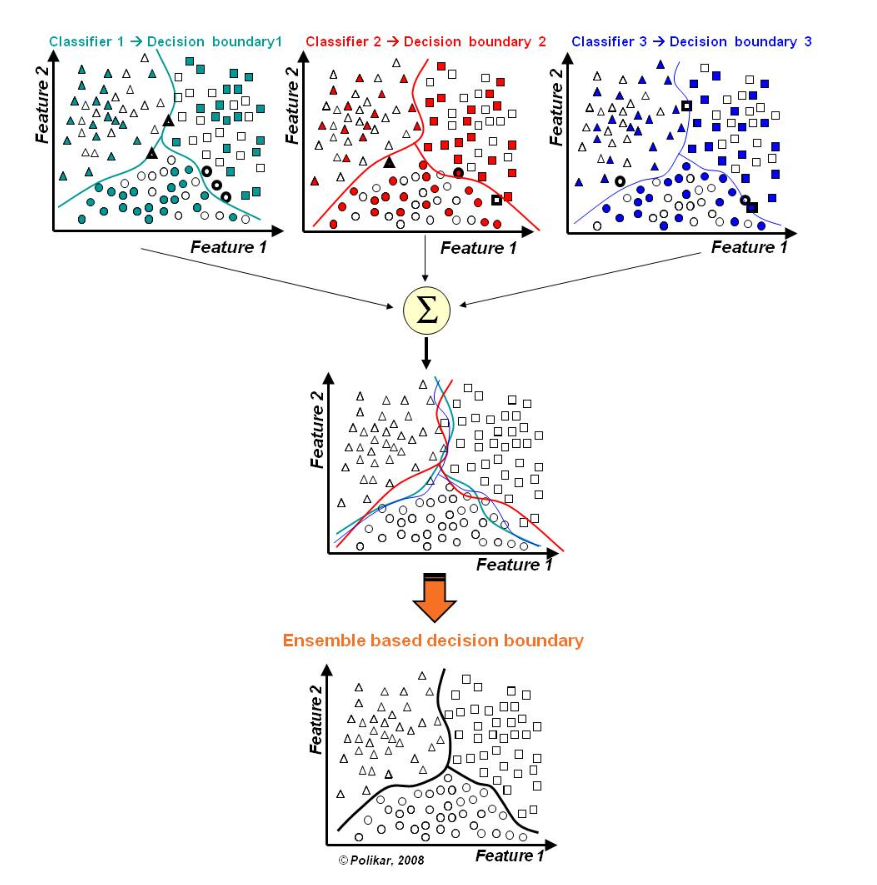

- Final Decision made by (weighted) voting from weak trees in the forest (ensemble). 

# Tuning Hyper-paramters (n_trees, learning_rate)

In [ ]:
seed=1851   
xNames = np.array(list(X_train))

XX=np.arange(100,1100,100)   ## 10 by 10 grid search
YY=np.arange(0.0001,0.05,0.005)
Z= [ [0] * 10 for _ in range(10) ]

for i in range(10):           
    for j in range(10):  
      params = {'n_estimators': XX[i], 'learning_rate': YY[j]}
      m = ensemble.GradientBoostingClassifier(**params,random_state=seed)
      m.fit(X_train, y_train)
      acc1=round(m.score(X_test, y_test),3)
      Z[i][j]=acc1
      print(i, j, acc1)


0 0 0.539
0 1 0.708
0 2 0.71
0 3 0.71
0 4 0.712
0 5 0.713
0 6 0.706
0 7 0.71
0 8 0.71
0 9 0.712
1 0 0.539
1 1 0.712
1 2 0.712
1 3 0.71
1 4 0.704
1 5 0.708
1 6 0.712
1 7 0.695
1 8 0.693
1 9 0.697
2 0 0.539
2 1 0.712
2 2 0.708
2 3 0.712
2 4 0.706
2 5 0.7
2 6 0.699
2 7 0.676
2 8 0.672
2 9 0.674
3 0 0.539
3 1 0.712
3 2 0.71
3 3 0.71
3 4 0.693
3 5 0.685
3 6 0.682
3 7 0.676
3 8 0.67
3 9 0.678
4 0 0.539
4 1 0.713
4 2 0.712
4 3 0.702
4 4 0.685
4 5 0.678
4 6 0.672
4 7 0.67
4 8 0.67
4 9 0.674
5 0 0.539
5 1 0.708
5 2 0.704
5 3 0.693
5 4 0.676
5 5 0.674
5 6 0.676
5 7 0.667
5 8 0.674
5 9 0.676
6 0 0.539
6 1 0.704
6 2 0.695
6 3 0.684
6 4 0.676
6 5 0.684
6 6 0.669
6 7 0.682
6 8 0.67
6 9 0.669
7 0 0.539
7 1 0.71
7 2 0.693
7 3 0.684
7 4 0.67
7 5 0.68
7 6 0.672
7 7 0.674
7 8 0.67
7 9 0.667
8 0 0.539
8 1 0.713
8 2 0.689
8 3 0.685
8 4 0.676
8 5 0.672
8 6 0.676
8 7 0.676
8 8 0.665
8 9 0.669
9 0 0.539
9 1 0.712
9 2 0.67
9 3 0.674
9 4 0.672
9 5 0.672
9 6 0.669
9 7 0.672
9 8 0.667
9 9 0.674


# Contour plot (Z=hit rate for y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'color'
  This is separate from the ipykernel package so we can avoid doing imports until


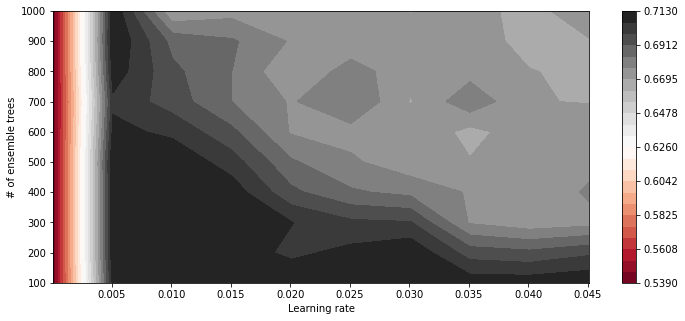

In [ ]:
plt.figure(figsize=(12, 5))
cp = plt.contourf(YY, XX, Z, cmap='RdGy',  color='black',
                 levels = np.linspace(np.min(Z), np.max(Z), 25) )
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 12}

plt.colorbar(cp)
plt.xlabel('Learning rate')        
plt.ylabel('# of ensemble trees')   
#plt.savefig('1727.svg')
plt.show()

## Final run with optimaized hyper parameters (n_tree=500, learning rate=0.03)

In [ ]:
seed=1851   
xNames = np.array(list(X_train))

params = {'n_estimators': 500,           ##  300
          'learning_rate': 0.03}         ## 0.033

m = ensemble.GradientBoostingClassifier(**params,random_state=seed)
m.fit(X_train, y_train)
acc1=round(m.score(X_test, y_test),3)
acc2=round(m.score(X_train, y_train),3)

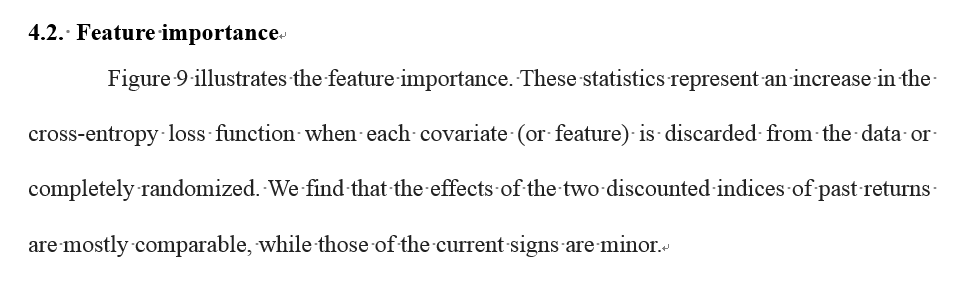

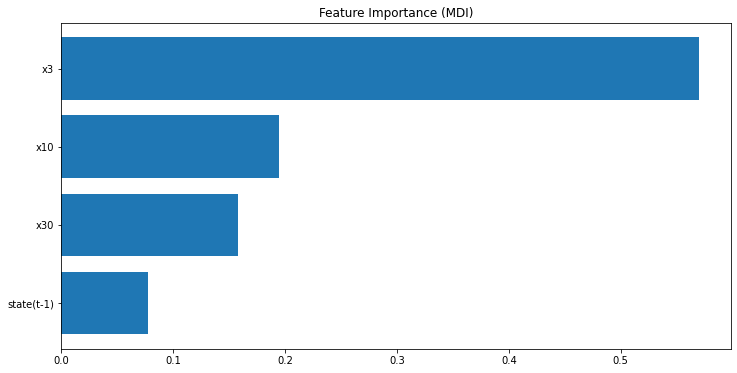

In [ ]:
#feature_importance = m.feature_importances_/np.max(m.feature_importances_)
feature_importance = m.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(xNames)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(m, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=np.array(xNames)[sorted_idx])
#plt.title("Permutation Importance (test set)")
#fig.tight_layout()
plt.show()

# Training Fit

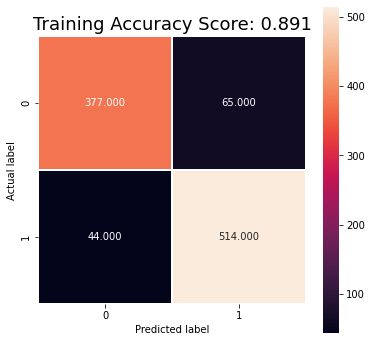

In [ ]:
import seaborn as sn 
from sklearn.metrics import accuracy_score, confusion_matrix 

acc=round(m.score(X_train, y_train),3)
con_mat = confusion_matrix(y_true=y_train, y_pred= m.predict(X_train)) 

# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Training Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

# Test Fit

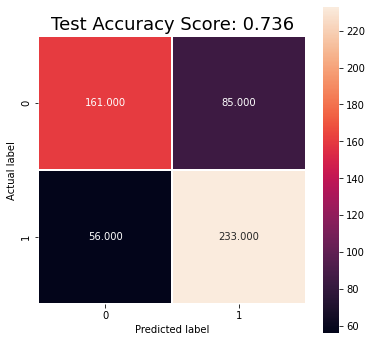

In [ ]:
acc=round(m.score(X_test, y_test),3)
con_mat = confusion_matrix(y_true=y_test, y_pred= m.predict(X_test)) 

# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Test Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

# 예측력이 이미 SDAE를 넘어섭니다. 주가 골드프라이스 등 몇가지 추가하면 더 높아질 것입니다. 

# 로지스틱 회귀모형보다 훨씬 우수합니다. 

0.567
0.5439252336448598


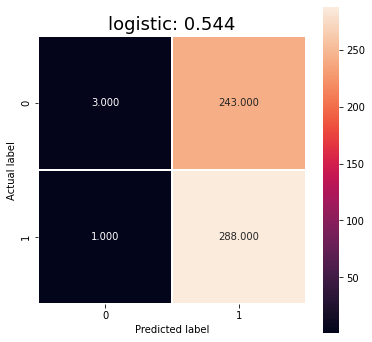

In [ ]:
from sklearn.linear_model import LogisticRegression

#print 'Train LogisticRegression()'
clf_init = LogisticRegression();
clf_init.fit(X_train, y_train);
clf_init.fit

print(clf_init.score(X_train, y_train))   ## 로지스틱 리그레션 설명
print(clf_init.score(X_test, y_test))     ## 로지스틱 리그레션 예측
#print 'Train LogisticRegression() is done'
#clf_init.coef_

y_logit=clf_init.predict(X_test)

acc=round(clf_init.score(X_test, y_test), 3)
con_mat = confusion_matrix(y_true=y_test, y_pred= y_logit) 

# 아래를 블럭 실행하기
# confusion matrix heatmap  
plt.figure(figsize=(6,6)) # chart size 
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'logistic: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

# Visualizing Covariate Effects by PDP
# 이 결과를 잘 해석하는 것이 필요합니다.

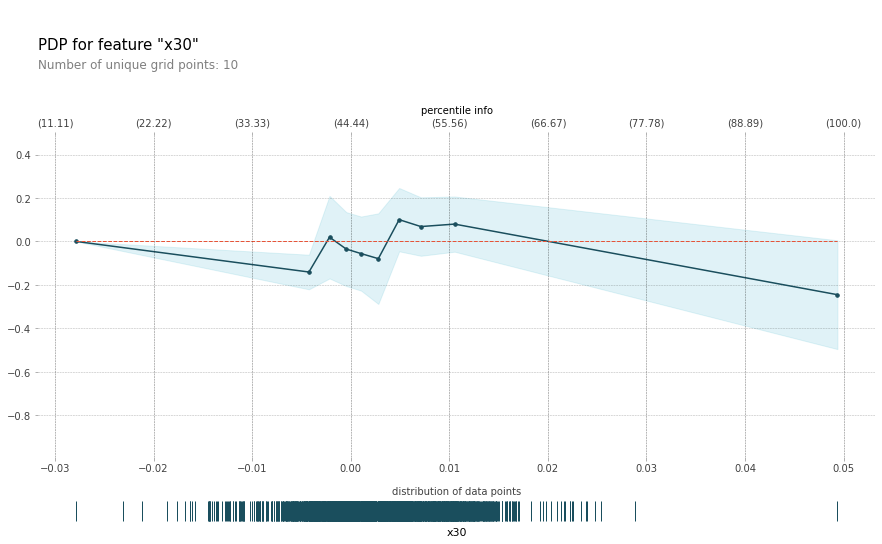

In [ ]:
from pdpbox import pdp, info_plots
k=xNames[3]
pdp_1 = pdp.pdp_isolate(model=m, dataset=X, model_features=list(X), feature=k)
#PDP Plot0
fig, axes = pdp.pdp_plot(pdp_1, k, plot_lines=False, center=True, frac_to_plot=0.5, plot_pts_dist=True,x_quantile=False, show_percentile=True)
#ICE Plot
#fig, axes = pdp.pdp_plot(pdp_1, k, plot_lines=True, center=True, frac_to_plot=1, plot_pts_dist=True,x_quantile=True, show_percentile=True)


# Interaction Effect

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc1ce18b690>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc1ce0956d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


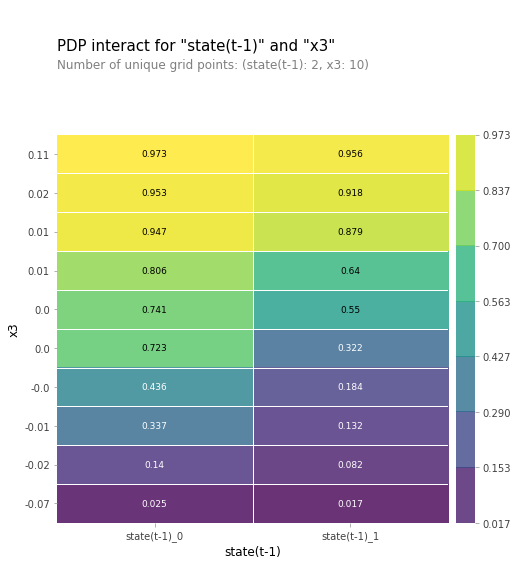

In [ ]:
k1=xNames[0]
k2=xNames[1]

# Two variable interaction plot
inter= pdp.pdp_interact(model=m, dataset=X_train, model_features=X_train.columns,
                             features=[k1,k2])
pdp.pdp_interact_plot(inter, [k1,k2], x_quantile=False, plot_type='grid', plot_pdp=False) 

# 변동 방향과 크기를 모두 예측한 다음, 방향은 잘되는데 크기는 안된다.
# 이렇게 보일수도 있겠지요. 전 크기는 안될거라고 생각합니다. 

# K-Fold 교차검증

https://velog.io/@skyepodium/K-Fold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D#1-kfold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D
